In [1]:
import pandas as pd
import numpy as np

import random 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix

torch.manual_seed(666)

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW

import warnings
warnings.filterwarnings('ignore')

print(torch.__version__)

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
# pip install seaborn
#import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset
from azureml.core import Workspace

1.8.1


In [2]:
# get the configs for the Azure Workspace
ws = Workspace.from_config()
# initialize location of the data (blob)
datastore_name = 'mlthesisdatablob'
dataset_name='data.cleaned.raw'
#load the data of english examples
datastore = Datastore.get(ws, datastore_name)
datapath = datastore.path('data_all_lang.csv')
dataset = Dataset.auto_read_files(datapath)

d = dataset.register(workspace=ws, name=dataset_name, exist_ok=True, update_if_exist=True)

dataset = Dataset.get(ws,dataset_name)
# create a dataframe
df = dataset.to_pandas_dataframe()



#Alternatively: Load data from csv in your directory 


#df = pd.read_csv('data_all_lang.csv')

#df.head()
## Preprocessing 

# create a dataset for each language

df_en = df[df.lang_final=='en']
df_es = df[df.lang_final=='es']
df_it = df[df.lang_final=='it']
df_hi = df[df.lang_final=='hi']
df_pt = df[df.lang_final=='pt']
df_fr = df[df.lang_final=='fr']

# reset the indicies

df_en.reset_index(drop=True, inplace=True)
df_es.reset_index(drop=True, inplace=True)
df_it.reset_index(drop=True, inplace=True)
df_hi.reset_index(drop=True, inplace=True)
df_pt.reset_index(drop=True, inplace=True)
df_fr.reset_index(drop=True, inplace=True)

"Dataset.auto_read_files" is deprecated after version 1.0.69. Please use "Dataset.Tabular.from_delimited_files" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.
DatasetDefinition class is deprecated after version 1.0.69. See Dataset API change notice at https://aka.ms/dataset-deprecation.
The constructor of Dataset is deprecated after version 1.0.69. Please use factory methods from "Dataset.Tabular" and "Dataset.File" to create dataset instances. See Dataset API change notice at https://aka.ms/dataset-deprecation.
"Dataset.get" is deprecated after version 1.0.69. Please use "Dataset.get_by_name" and "Dataset.get_by_id" to retrieve dataset. See Dataset API change notice at https://aka.ms/dataset-deprecation.


13057


In [3]:
df.duplicated().any()

False

In [4]:
def train_val_test_split_df(df, test_size , val_size, random_state, stratify_column):
    # create a intermediary df and the test set
    val_s = val_size/(1-test_size)
    df_int, df_test = train_test_split(df,
                                       stratify=df[stratify_column],
                                       test_size=test_size,
                                       random_state=random_state)
    df_train, df_val = train_test_split(df_int,
                                       stratify=df_int[stratify_column],
                                       test_size=test_size,
                                       random_state=random_state)
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    
    return df_train, df_val, df_test

In [5]:
# initialize tokenizer

MODEL_TYPE = 'xlm-roberta-base'

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)

#from transformers import XLMRobertaForSequenceClassification

model = XLMRobertaForSequenceClassification.from_pretrained(
    MODEL_TYPE, 
    num_labels = 2, # The number of output labels. 2 for binary classification.
)

# Send the model to the device.
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [6]:
"""The code for the following cell was created using inspiration from : 
https://www.kaggle.com/vbookshelf/basics-of-bert-and-xlm-roberta-pytorch"""


class CompDataset(Dataset):
    
    def __init__(self, df):
        self.df_data = df
        
    def __getitem__(self, index):
        
        text = self.df_data.loc[index, 'text_feat_clean']
        
        
        encoded_dict = tokenizer.encode_plus(text,
                                             add_special_tokens = True,
                                             max_length = 512,
                                             truncation=True,
                                             pad_to_max_length=True,
                                             return_attention_mask=True,
                                             return_tensors ='pt')
        
        # These are torch tensors already.
        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]

        
        # Convert the target to a torch tensor
        target = torch.tensor(self.df_data.loc[index, 'target'])

        sample = (padded_token_list, att_mask, target)

        return sample
    
    def __len__(self):
        return len(self.df_data)


In [7]:
"""The code for the following cell was created using inspiration from : 
https://www.kaggle.com/vbookshelf/basics-of-bert-and-xlm-roberta-pytorch"""

def train(train_dataloader, optimizer, NUM_EPOCHS, model_name):    



    # Set the seed.
    seed_val = 101

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store the average loss after each epoch so we can plot them.
    loss_values = []


    # For each epoch...
    for epoch in range(0, NUM_EPOCHS):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))


        stacked_val_labels = []
        targets_list = []

        # ========================================
        #               Training
        # ========================================

        print('Training...')

        # put the model into train mode
        model.train()

        # This turns gradient calculations on and off.
        torch.set_grad_enabled(True)


        # Reset the total loss for this epoch.
        total_train_loss = 0

        for i, batch in enumerate(train_dataloader):

            train_status = 'Batch ' + str(i) + ' of ' + str(len(train_dataloader))

            print(train_status, end='\r')


            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        


            outputs = model(b_input_ids, 
                        attention_mask=b_input_mask,
                        labels=b_labels)

            # Get the loss from the outputs tuple: (loss, logits)
            loss = outputs[0]

            # Convert the loss from a torch tensor to a number.
            # Calculate the total loss.
            total_train_loss = total_train_loss + loss.item()

            # Zero the gradients
            optimizer.zero_grad()

            # Perform a backward pass to calculate the gradients.
            loss.backward()


            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Use the optimizer to update the weights.
            optimizer.step() 



        print('Train loss:' ,total_train_loss/len(train_dataloader))


        # ========================================
        #               Validation
        # ========================================

        print('\nValidation...')

        # Put the model in evaluation mode.
        model.eval()

        # Turn off the gradient calculations.
        # This tells the model not to compute or store gradients.
        # This step saves memory and speeds up validation.
        torch.set_grad_enabled(False)


        # Reset the total loss for this epoch.
        total_val_loss = 0


        for j, batch in enumerate(val_dataloader):

            val_status = 'Batch ' + str(j) + ' of ' + str(len(val_dataloader))

            print(val_status, end='\r')

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)      


            outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

            # Get the loss from the outputs tuple: (loss, logits)
            loss = outputs[0]

            # Convert the loss from a torch tensor to a number.
            # Calculate the total loss.
            total_val_loss = total_val_loss + loss.item()


            # Get the preds
            preds = outputs[1]


            # Move preds to the CPU
            val_preds = preds.detach().cpu().numpy()

            # Move the labels to the cpu
            targets_np = b_labels.to('cpu').numpy()

            # Append the labels to a numpy list
            targets_list.extend(targets_np)

            if j == 0:  # first batch
                stacked_val_preds = val_preds

            else:
                stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


        # Calculate the validation accuracy
        y_true = targets_list
        y_pred = np.argmax(stacked_val_preds, axis=1)

        val_acc = accuracy_score(y_true, y_pred)


        print('Val loss:' ,total_val_loss/len(val_dataloader))
        print('Val acc: ', val_acc)


        # Save the Model
        torch.save(model.state_dict(), model_name+'.pt')

    return model, loss_values


def evaluate(test_dataloader, model):    
    targets_list = []
    for j, batch in enumerate(test_dataloader):

            inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))

            print(inference_status, end='\r')

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids, 
                    attention_mask=b_input_mask)


            # Get the preds
            preds = outputs[0]


            # Move preds to the CPU
            preds = preds.detach().cpu().numpy()

            # Move the labels to the cpu
            targets_np = b_labels.to('cpu').numpy()

            # Append the labels to a numpy list
            targets_list.extend(targets_np)

            # Stack the predictions.

            if j == 0:  # first batch
                stacked_preds = preds

            else:
                stacked_preds = np.vstack((stacked_preds, preds))
            
    y_true = targets_list
    y_pred = np.argmax(stacked_preds, axis=1)
    
    return y_true, y_pred
            

def x_language_eval(dataloader, model, fig_name):
    y_true, y_pred = evaluate(dataloader, model)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    #figure = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')
    #fig = figure.get_figure()
    #fig.savefig(fig_name)
    
def ouput_creator(train_lang, model, d_dataloader):
    
    for i in d_dataloader:
        if i != train_lang:
            print('============='+train_lang +' - '+i+'=============')
            x_language_eval(d_dataloader[i], model, train_lang+'_'+i+'_b.png')
        else:
            print('============='+train_lang +' - '+i+'=============')
            x_language_eval(test_dataloader, model, i+'_'+i+'_b.png')


In [8]:
L_RATE = 2e-5

NUM_EPOCHS = 3
BATCH_SIZE = 8
NUM_CORES = 6

DF = df_fr

MODEL_NAME = 'model_fr_unbalanced'

# Define the optimizer
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8 
            )


df_train, df_val, df_test = train_val_test_split_df(DF, 0.1,0.2,123, 'target')

train_data = CompDataset(df_train)
val_data = CompDataset(df_val)
test_data = CompDataset(df_test)


train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        sampler = RandomSampler(train_data),
                                       num_workers=NUM_CORES)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(val_data),
                                       num_workers=NUM_CORES)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=BATCH_SIZE,
                                              sampler=SequentialSampler(test_data), 
                                              num_workers=NUM_CORES)


english_dataloader = torch.utils.data.DataLoader(CompDataset(df_en),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)



spanish_dataloader = torch.utils.data.DataLoader(CompDataset(df_es),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

italian_dataloader = torch.utils.data.DataLoader(CompDataset(df_it),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

hindi_dataloader = torch.utils.data.DataLoader(CompDataset(df_hi),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

portuguese_dataloader = torch.utils.data.DataLoader(CompDataset(df_pt),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

french_dataloader = torch.utils.data.DataLoader(CompDataset(df_fr),
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

d_dataloader = {'en':english_dataloader,
                'es':spanish_dataloader,
                'it':italian_dataloader,
                'hi':hindi_dataloader,
                'pt':portuguese_dataloader, 
                'fr':french_dataloader}

In [9]:
model, loss_stats = train(train_dataloader, optimizer, NUM_EPOCHS, MODEL_NAME)    


======== Epoch 1 / 3 ========
Training...
Train loss: 0.34404488173785847

Validation...
Val loss: 0.2360971526359208
Val acc:  0.8870967741935484

======== Epoch 2 / 3 ========
Training...
Train loss: 0.20151745975591187

Validation...
Val loss: 0.07112256623440771
Val acc:  0.9516129032258065

======== Epoch 3 / 3 ========
Training...
Train loss: 0.13682901209550977

Validation...
Val loss: 0.30701520765796886
Val acc:  0.9516129032258065


=============en - en=============
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       462
           1       0.96      0.92      0.94       330

    accuracy                           0.95       792
   macro avg       0.95      0.95      0.95       792
weighted avg       0.95      0.95      0.95       792

[[449  13]
 [ 26 304]]
=============en - es=============
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1291
           1       0.40      0.86      0.55       168

    accuracy                           0.84      1459
   macro avg       0.69      0.85      0.73      1459
weighted avg       0.91      0.84      0.86      1459

[[1077  214]
 [  23  145]]
=============en - it=============
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1076
           1       0.11      0.88      0.19        42

    accuracy                  

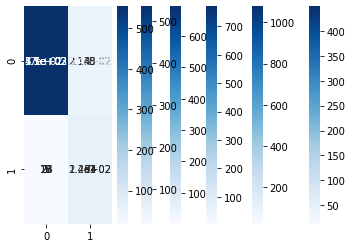

In [10]:
# model no balancing strategy

ouput_creator('en', model,d_dataloader)

In [12]:
ouput_creator('es', model,d_dataloader)

=============es - en=============
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      4615
           1       0.80      0.57      0.66      3298

    accuracy                           0.76      7913
   macro avg       0.77      0.73      0.74      7913
weighted avg       0.77      0.76      0.75      7913

[[4146  469]
 [1422 1876]]
=============es - es=============
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       129
           1       1.00      0.71      0.83        17

    accuracy                           0.97       146
   macro avg       0.98      0.85      0.90       146
weighted avg       0.97      0.97      0.96       146

[[129   0]
 [  5  12]]
=============es - it=============
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1076
           1       0.23      0.48      0.31        42

    accuracy                  

In [10]:
ouput_creator('it', model,d_dataloader)

=============it - en=============
              precision    recall  f1-score   support

           0       0.75      0.43      0.55      4615
           1       0.50      0.80      0.61      3298

    accuracy                           0.58      7913
   macro avg       0.62      0.61      0.58      7913
weighted avg       0.64      0.58      0.57      7913

[[1984 2631]
 [ 674 2624]]
=============it - es=============
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1291
           1       0.49      0.59      0.54       168

    accuracy                           0.88      1459
   macro avg       0.72      0.76      0.74      1459
weighted avg       0.89      0.88      0.89      1459

[[1190  101]
 [  69   99]]
=============it - it=============
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       108
           1       0.75      0.75      0.75         4

    accuracy              

In [10]:
ouput_creator('hi', model,d_dataloader)

=============hi - en=============
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      4615
           1       0.68      0.80      0.73      3298

    accuracy                           0.76      7913
   macro avg       0.76      0.76      0.76      7913
weighted avg       0.77      0.76      0.76      7913

[[3368 1247]
 [ 663 2635]]
=============hi - es=============
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1291
           1       0.34      0.80      0.48       168

    accuracy                           0.80      1459
   macro avg       0.65      0.80      0.68      1459
weighted avg       0.90      0.80      0.83      1459

[[1030  261]
 [  33  135]]
=============hi - it=============
              precision    recall  f1-score   support

           0       0.99      0.50      0.67      1076
           1       0.06      0.88      0.12        42

    accuracy              

In [10]:
ouput_creator('pt', model,d_dataloader)

=============pt - en=============
              precision    recall  f1-score   support

           0       0.79      0.60      0.68      4615
           1       0.58      0.78      0.66      3298

    accuracy                           0.67      7913
   macro avg       0.68      0.69      0.67      7913
weighted avg       0.70      0.67      0.67      7913

[[2768 1847]
 [ 742 2556]]
=============pt - es=============
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1291
           1       0.40      0.74      0.52       168

    accuracy                           0.84      1459
   macro avg       0.68      0.80      0.71      1459
weighted avg       0.90      0.84      0.86      1459

[[1108  183]
 [  44  124]]
=============pt - it=============
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      1076
           1       0.13      0.57      0.22        42

    accuracy              

In [10]:
ouput_creator('fr', model,d_dataloader)

=============fr - en=============
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      4615
           1       0.58      0.58      0.58      3298

    accuracy                           0.65      7913
   macro avg       0.64      0.64      0.64      7913
weighted avg       0.65      0.65      0.65      7913

[[3223 1392]
 [1378 1920]]
=============fr - es=============
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1291
           1       0.85      0.57      0.68       168

    accuracy                           0.94      1459
   macro avg       0.90      0.78      0.82      1459
weighted avg       0.93      0.94      0.93      1459

[[1274   17]
 [  73   95]]
=============fr - it=============
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1076
           1       0.28      0.69      0.40        42

    accuracy              